In [1]:
import os
from google.cloud import bigquery
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import pickle

In [11]:
base_model_dir = 'bucket/models'

In [2]:
PROJECT_ID = "integrated-bit-312717"
DATASET_NAME = 'customs'
TABLE_NAME = "customs_test3"

table_id = "{project_id}.{dataset_name}.{table_name}".format(project_id=PROJECT_ID, dataset_name=DATASET_NAME, 
            table_name=TABLE_NAME)
table_id

'integrated-bit-312717.customs.customs_test3'

In [3]:
client = bigquery.Client(project=PROJECT_ID, location="US")

In [13]:
query_job = client.query(
    """
        SELECT DISTINCT `country` from `{table_id}` 
    """.format(table_id=table_id)
)
result = query_job.result()
print(result)
countrys = [row.country for row in result]
countrys.sort()
countrys

['&Aring;LAND ISLANDS',
 'AFGHANISTAN',
 'ALBANIA',
 'ALGERIA',
 'AMERICAN SAMOA',
 'ANDORRA',
 'ANGOLA',
 'ANGUILLA',
 'ANTARCTICA',
 'ANTIGUA AND BARBUDA',
 'ARGENTINA',
 'ARMENIA',
 'ARUBA',
 'AUSTRALIA',
 'AUSTRIA',
 'AZERBAIJAN',
 'BAHAMAS',
 'BAHRAIN',
 'BANGLADESH',
 'BARBADOS',
 'BELARUS',
 'BELGIUM',
 'BELIZE',
 'BENIN',
 'BERMUDA',
 'BHUTAN',
 'BOLIVIA',
 'BONAIRE,SAINT EUSTATIUS AND SABA',
 'BOSNIA AND HERZEGOVINA    ',
 'BOTSWANA',
 'BOUVET ISLAND',
 'BRAZIL',
 'BRITISH INDIAN OCEAN TERRITORY',
 'BRUNEI DARUSSALAM',
 'BULGARIA',
 'BURKINA FASO',
 'BURUNDI',
 'CAMBODIA',
 'CAMEROON',
 'CANADA',
 'CAPE VERDE',
 'CAYMAN ISLANDS',
 'CENTRAL AFRICAN REPUBLIC',
 'CHAD',
 'CHILE',
 'CHINA',
 'CHRISTMAS ISLAND',
 'COCOS (KEELING) ISLANDS',
 'COLOMBIA',
 'COMOROS',
 'CONGO',
 'CONGO, THE DEMOCRATIC REPUBLIC OF T',
 'COOK ISLANDS',
 'COSTA RICA',
 'COTE D IVOIRE',
 'CROATIA',
 'CUBA',
 'CURACAO',
 'CYPRUS',
 'CZECH REPUBLIC',
 'DDD',
 'DENMARK',
 'DJIBOUTI',
 'DOMINICA',
 'DOMINICAN 

In [17]:
types = ['import', 'export']

In [19]:
query_job = client.query(
    """
        SELECT country, hs_code, value, type, year_month FROM `integrated-bit-312717.customs.customs_test3` 
        WHERE (`country`="THAILAND" AND `value`!=0 AND `hs_code`="8542")
    """
)
result = query_job.result()
print(result)
data = [
    {
        'country':row.country,
        'hs_code':row.hs_code,
        'type':row.type,
        'value':row.value,
        'year_month':row.year_month
    } for row in result ]

In [20]:
df = pd.DataFrame(data)
df = df.sort_values(by='year_month')
df

,country,hs_code,type,value,year_month
70,THAILAND,8542,import,251480322,2001-01
5,THAILAND,8542,import,178914246,2001-02
8,THAILAND,8542,import,163095022,2001-03
23,THAILAND,8542,import,349826165,2001-04
19,THAILAND,8542,import,322581073,2001-05
...,...,...,...,...,...
214,THAILAND,8542,import,2123325954,2020-10
198,THAILAND,8542,import,1582686767,2020-11
228,THAILAND,8542,import,1718695994,2020-12
2,THAILAND,8542,import,2077444177,2021-01


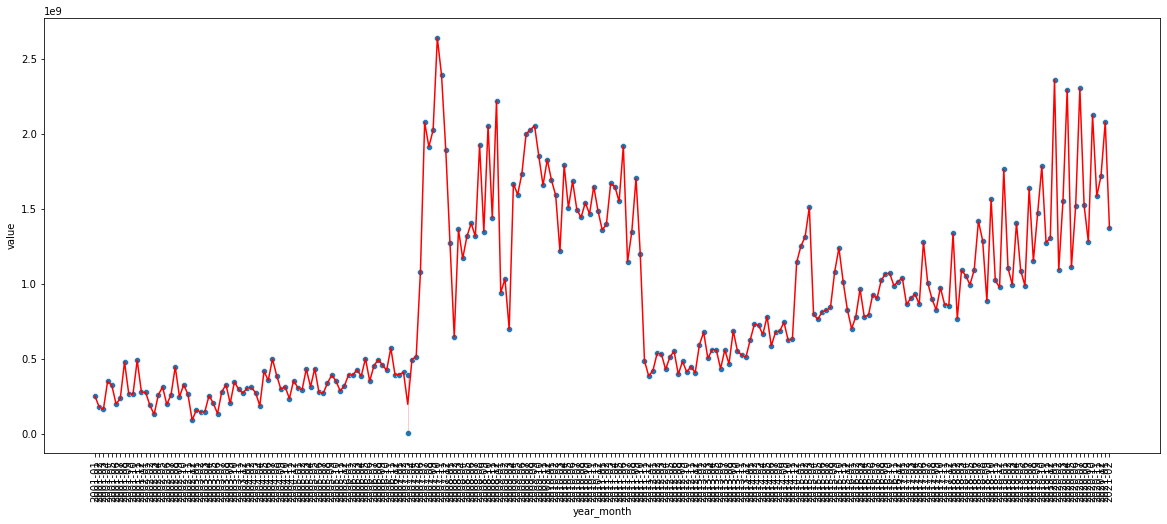

In [21]:
plt.figure(figsize=(20,8))
sns.scatterplot(x='year_month', y='value',data=df)
sns.lineplot(x='year_month', y='value',data=df, color='r')
plt.xticks(rotation=90)
plt.show()

In [22]:
ls bucket/models

passive_aggressive_regressor.sk  sgd_regressor.sk


In [34]:
with open(os.path.join(base_model_dir,'sgd_regressor.sk'), 'rb') as f:
    sgd_regressor = pickle.load(f)
with open(os.path.join(base_model_dir,'passive_aggressive_regressor.sk'), 'rb') as f:
    passive_aggressive_regressor = pickle.load(f)

In [24]:
df['country']=df['country'].apply(lambda x: countrys.index(x))
df['type']=df['type'].apply(lambda x: types.index(x))
df['year']=df['year_month'].apply(lambda x: int(x.split('-')[0]))
df['month']=df['year_month'].apply(lambda x: int(x.split('-')[1]))
df

,country,hs_code,type,value,year_month,year,month
70,226,8542,0,251480322,2001-01,2001,1
5,226,8542,0,178914246,2001-02,2001,2
8,226,8542,0,163095022,2001-03,2001,3
23,226,8542,0,349826165,2001-04,2001,4
19,226,8542,0,322581073,2001-05,2001,5
...,...,...,...,...,...,...,...
214,226,8542,0,2123325954,2020-10,2020,10
198,226,8542,0,1582686767,2020-11,2020,11
228,226,8542,0,1718695994,2020-12,2020,12
2,226,8542,0,2077444177,2021-01,2021,1


In [27]:
X = df.drop(['value','year_month'], axis=1).to_numpy()
X

array([[226, '8542', 0, 2001, 1],
       [226, '8542', 0, 2001, 2],
       [226, '8542', 0, 2001, 3],
       ...,
       [226, '8542', 0, 2020, 12],
       [226, '8542', 0, 2021, 1],
       [226, '8542', 0, 2021, 2]], dtype=object)

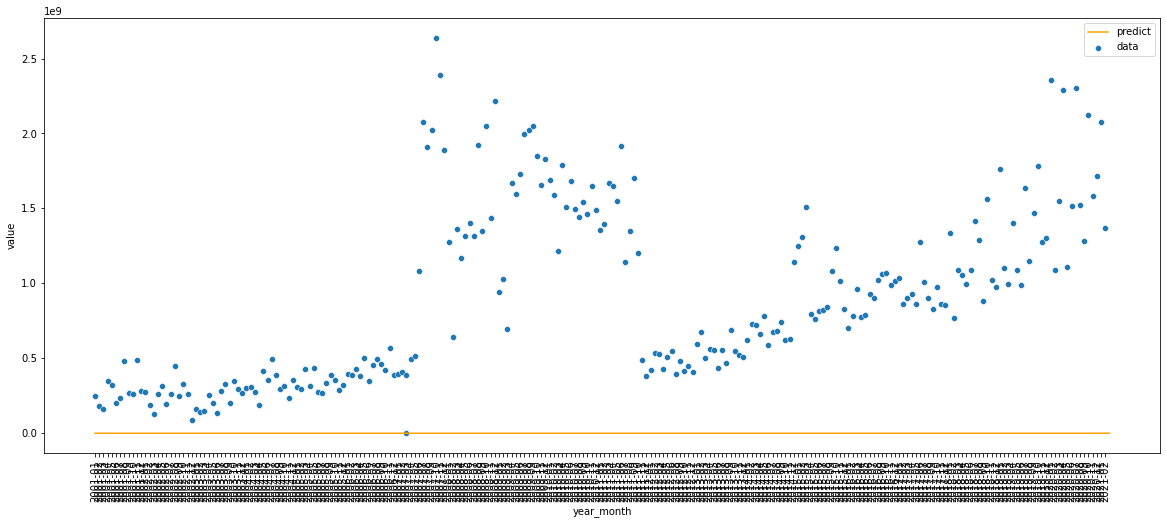

In [41]:
pred = sgd_regressor.predict(X)

plt.figure(figsize=(20,8))
plt.title()
sns.scatterplot(x='year_month', y='value',data=df, label='data')
sns.lineplot(data=pred, color='orange', label='predict')
plt.xticks(rotation=90)
plt.legend()
plt.show()

<AxesSubplot:>

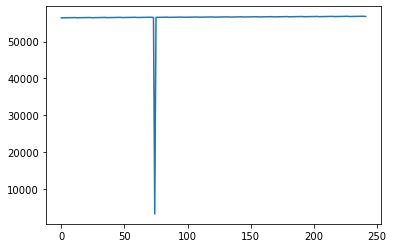

In [36]:
pred = passive_aggressive_regressor.predict(X)

plt.figure(figsize=(20,8))
sns.scatterplot(x='year_month', y='value',data=df, label='data')
sns.lineplot(data=pred, color='orange', label='predict')
plt.xticks(rotation=90)
plt.legend()
plt.show()